#Recomendador de películas

Referencia: https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

In [96]:
!pip install surprise

In [97]:
import pandas as pd
import numpy as np 
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [98]:
credits_df=pd.read_csv('https://raw.githubusercontent.com/sd12832/MoViZ/master/src/tmdb_5000_credits.csv')
movies_df=pd.read_csv('https://raw.githubusercontent.com/sd12832/MoViZ/master/src/tmdb_5000_movies.csv')

movie_id - A unique identifier for each movie.

cast - The name of lead and supporting actors.

crew - The name of Director, Editor, Composer, Writer etc.

In [99]:
credits_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


budget - The budget in which the movie was made.

genre - The genre of the movie, Action, Comedy ,Thriller etc.

homepage - A link to the homepage of the movie.

id - This is infact the movie_id as in the first dataset.

keywords - The keywords or tags related to the movie.

original_language - The language in which the movie was made.

original_title - The title of the movie before translation or adaptation.

overview - A brief description of the movie.

popularity - A numeric quantity specifying the movie popularity.

production_companies - The production house of the movie.

production_countries - The country in which it was produced.

release_date - The date on which it was released.

revenue - The worldwide revenue generated by the movie.

runtime - The running time of the movie in minutes.

status - "Released" or "Rumored".

tagline - Movie's tagline.

title - Title of the movie.

vote_average - average ratings the movie recieved.

vote_count - the count of votes recieved.

In [100]:
movies_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Unimos los dos datasets:

In [101]:
credits_df = credits_df.rename(columns = {'movie_id':'id'})#Hacemos coincidir el nombre de la columna por la que hacemos join
joined_df = credits_df.merge(movies_df.drop(columns=['title']),on='id')#La columna title está repetida
joined_df.head()

,id,title,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124


##Weighted rating (IMDB)

Podríamos usar la nota media de la película como puntuación, pero no sería justo que una película con una nota muy alta, pero muy pocos votos, fuera considerada mejor que una película con una nota algo más baja pero muchísimos votos. Una fórmula bastante famosa para abordar este problema es la fórmula de weigthed rating (WR) de IMDB.

In [102]:
!wget https://images.slideplayer.com/24/7035085/slides/slide_6.jpg

--2022-01-24 10:50:21--  https://images.slideplayer.com/24/7035085/slides/slide_6.jpg
Resolving images.slideplayer.com (images.slideplayer.com)... 138.201.58.10, 144.76.153.40, 144.76.166.55, ...
Connecting to images.slideplayer.com (images.slideplayer.com)|138.201.58.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56770 (55K) [image/jpeg]
Saving to: ‘slide_6.jpg.1’

slide_6.jpg.1       100%[===================>]  55.44K  19.1KB/s    in 2.9s    

2022-01-24 10:50:25 (19.1 KB/s) - ‘slide_6.jpg.1’ saved [56770/56770]



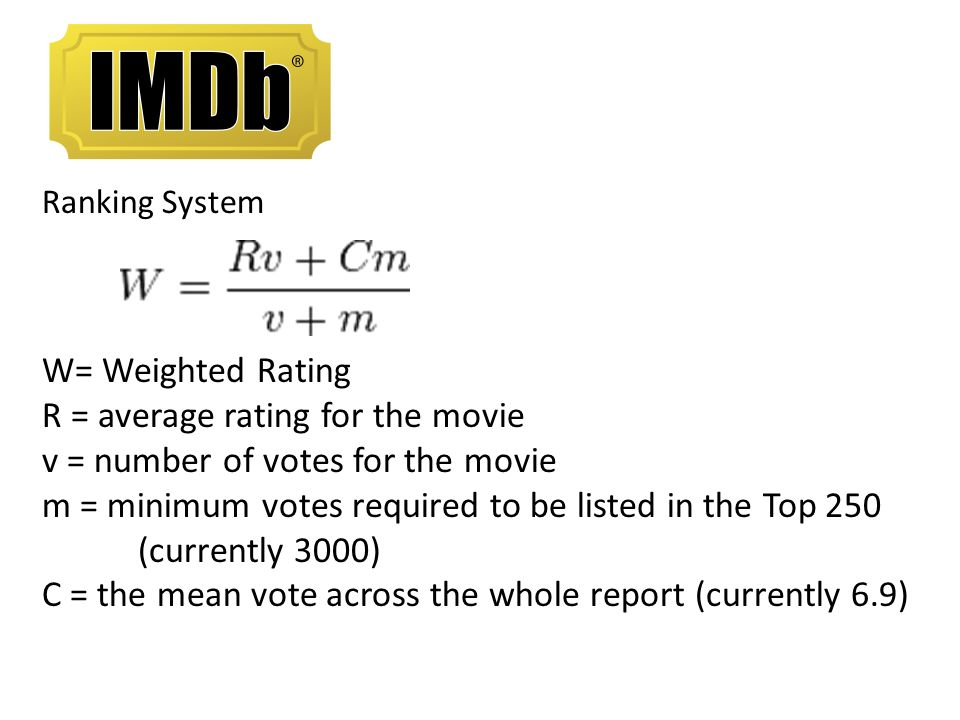

In [103]:
Image("slide_6.jpg")

Nota media de todas las películas

In [104]:
C= joined_df['vote_average'].mean()
C

6.092171559442011

Tenemos que calcular el número mínimo de votos para que una película sea considerada

In [105]:
joined_df['vote_count'].describe(percentiles=np.arange(0,1.05,0.05))

count     4803.000000
mean       690.217989
std       1234.585891
min          0.000000
0%           0.000000
5%           4.000000
10%         12.000000
15%         23.000000
20%         36.000000
25%         54.000000
30%         76.000000
35%        104.000000
40%        139.000000
45%        184.900000
50%        235.000000
55%        297.000000
60%        370.200000
65%        463.300000
70%        581.000000
75%        737.000000
80%        957.600000
85%       1300.700000
90%       1838.400000
95%       3040.900000
100%     13752.000000
max      13752.000000
Name: vote_count, dtype: float64

(0.0, 2000.0)

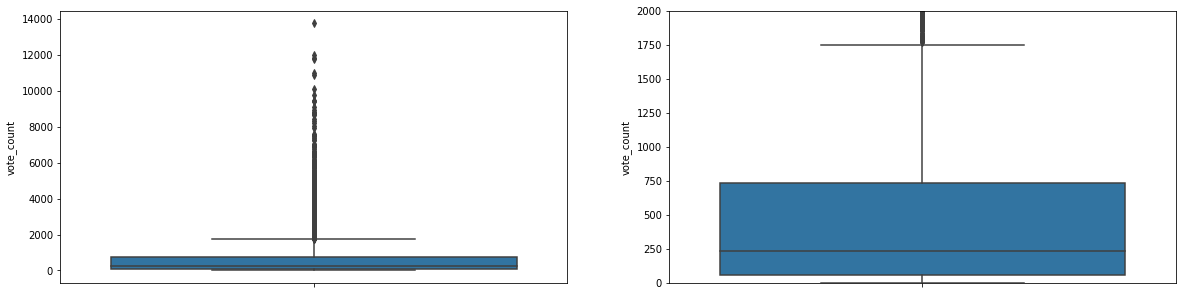

In [106]:
fig,axs = plt.subplots(1,2,figsize=(20,5))
sns.boxplot(data=joined_df,y='vote_count',ax=axs[0])
sns.boxplot(data=joined_df,y='vote_count',ax=axs[1])
axs[1].set_ylim(0,2000)

Escogemos el percentil 90 como mínimo número de votos requeridos:

In [107]:
m= joined_df['vote_count'].quantile(0.9)
m

1838.4000000000015

Hay 481 películas con más de "m" votos:

In [108]:
print(joined_df.shape)
joined_filtered_df = joined_df[joined_df['vote_count']>m]
print(joined_filtered_df.shape)

(4803, 22)
(481, 22)


Calculcamos el  weighted_rating:

In [109]:
joined_filtered_df['weighted_rating'] = (joined_filtered_df['vote_count']/(joined_filtered_df['vote_count']+m) * joined_filtered_df['vote_average']) + (m/(m+joined_filtered_df['vote_count']) * C)

In [110]:
joined_filtered_df[['title','vote_count','vote_average','weighted_rating']]

,title,vote_count,vote_average,weighted_rating
0,Avatar,11800,7.2,7.050669
1,Pirates of the Caribbean: At World's End,4500,6.9,6.665696
2,Spectre,4466,6.3,6.239396
3,The Dark Knight Rises,9106,7.6,7.346721
4,John Carter,2124,6.1,6.096368
...,...,...,...,...
4291,Saw,2184,7.2,6.693677
4300,Reservoir Dogs,3697,8.0,7.366378
4302,"The Good, the Bad and the Ugly",2311,8.1,7.210428
4337,Taxi Driver,2535,8.0,7.198026


Ordenamos por  weighted_rating:

In [111]:
joined_filtered_df_ordered = joined_filtered_df.sort_values('weighted_rating', ascending=False)

In [112]:
joined_filtered_df_ordered[['title','vote_count','vote_average','weighted_rating']]

,title,vote_count,vote_average,weighted_rating
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
...,...,...,...,...
41,Green Lantern,2487,5.1,5.521697
337,A Good Day to Die Hard,3493,5.2,5.507643
193,After Earth,2532,5.0,5.459420
91,Independence Day: Resurgence,2491,4.9,5.406234


Top 10 mejores películas:

In [113]:
joined_filtered_df_ordered[['title','vote_count','vote_average','weighted_rating']].head(10)

,title,vote_count,vote_average,weighted_rating
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Top 10 peores películas:

In [114]:
joined_filtered_df_ordered[['title','vote_count','vote_average','weighted_rating']].tail(10)

,title,vote_count,vote_average,weighted_rating
215,Fantastic 4: Rise of the Silver Surfer,2589,5.4,5.687412
148,Ghostbusters,2142,5.3,5.665875
166,G.I. Joe: Retaliation,3025,5.4,5.661646
61,Jupiter Ascending,2768,5.2,5.556063
1154,Fifty Shades of Grey,3254,5.2,5.522082
41,Green Lantern,2487,5.1,5.521697
337,A Good Day to Die Hard,3493,5.2,5.507643
193,After Earth,2532,5.0,5.459420
91,Independence Day: Resurgence,2491,4.9,5.406234
242,Fantastic Four,2278,4.4,5.155730


## Content-based filtering

In [115]:
!wget https://www.iiia.csic.es/media/filer_public_thumbnails/filer_public/a8/36/a836825f-7604-4670-aa5c-a03d72a904e7/recomsys.png__720x452_q85_subsampling-2.jpg

--2022-01-24 10:50:26--  https://www.iiia.csic.es/media/filer_public_thumbnails/filer_public/a8/36/a836825f-7604-4670-aa5c-a03d72a904e7/recomsys.png__720x452_q85_subsampling-2.jpg
Resolving www.iiia.csic.es (www.iiia.csic.es)... 158.109.36.15
Connecting to www.iiia.csic.es (www.iiia.csic.es)|158.109.36.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34091 (33K) [image/jpeg]
Saving to: ‘recomsys.png__720x452_q85_subsampling-2.jpg.1’

recomsys.png__720x4 100%[===================>]  33.29K  --.-KB/s    in 0s      

2022-01-24 10:50:26 (256 MB/s) - ‘recomsys.png__720x452_q85_subsampling-2.jpg.1’ saved [34091/34091]



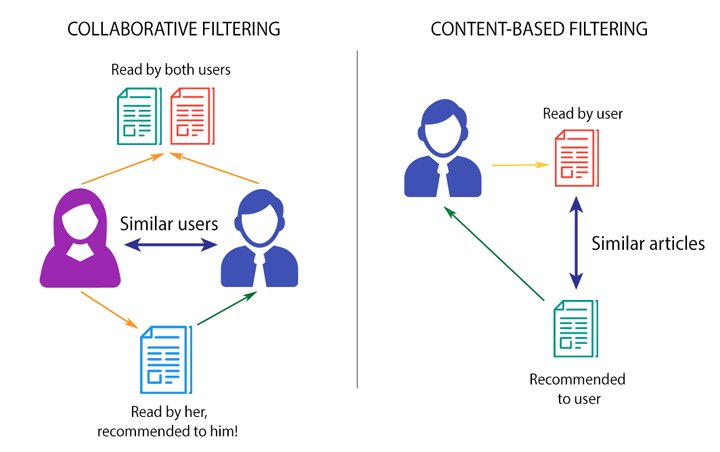

In [116]:
Image("recomsys.png__720x452_q85_subsampling-2.jpg")

In [117]:
joined_df[['title','overview']]

,title,overview
0,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,Following the death of District Attorney Harve...
4,John Carter,"John Carter is a war-weary, former military ca..."
...,...,...
4798,El Mariachi,El Mariachi just wants to play his guitar and ...
4799,Newlyweds,A newlywed couple's honeymoon is upended by th...
4800,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic..."
4801,Shanghai Calling,When ambitious New York attorney Sam is sent t...


In [118]:
joined_df['overview'][0:1].values

array(['In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'],
      dtype=object)

In [119]:
joined_df['overview'][1:2].values

array(['Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.'],
      dtype=object)

Algunas películas no tienen overview

In [120]:
joined_df['overview'].isna().sum()

3

In [121]:
joined_df[joined_df['overview'].isna()][['title','overview']]

,title,overview
2656,Chiamatemi Francesco - Il Papa della gente,NaN
4140,"To Be Frank, Sinatra at 100",NaN
4431,Food Chains,NaN


Muchos algoritmos no trabajan bien con nulos, así que los rellenamos con un texto vacío:

In [122]:
joined_df['overview'] = joined_df['overview'].fillna('')

In [123]:
joined_df['overview'].isna().sum()

0

In [124]:
joined_df[joined_df['title'].isin(['Chiamatemi Francesco - Il Papa della gente','To Be Frank, Sinatra at 100','Food Chains'])][['title','overview']]

,title,overview
2656,Chiamatemi Francesco - Il Papa della gente,
4140,"To Be Frank, Sinatra at 100",
4431,Food Chains,


###TF-IDF

https://es.wikipedia.org/wiki/Tf-idf

"El valor tf-idf aumenta proporcionalmente al número de veces que una palabra aparece en el documento, pero es compensada por la frecuencia de la palabra en la colección de documentos, lo que permite manejar el hecho de que algunas palabras son generalmente más comunes que otras."

In [125]:
!wget https://cdn-images-1.medium.com/max/720/1*jNnpbGPxkjehlvTCXq9B8g.png

--2022-01-24 10:50:27--  https://cdn-images-1.medium.com/max/720/1*jNnpbGPxkjehlvTCXq9B8g.png
Resolving cdn-images-1.medium.com (cdn-images-1.medium.com)... 162.159.153.4, 162.159.152.4, 2606:4700:7::a29f:9904, ...
Connecting to cdn-images-1.medium.com (cdn-images-1.medium.com)|162.159.153.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56162 (55K) [image/png]
Saving to: ‘1*jNnpbGPxkjehlvTCXq9B8g.png.1’

1*jNnpbGPxkjehlvTCX 100%[===================>]  54.85K  --.-KB/s    in 0s      

2022-01-24 10:50:27 (108 MB/s) - ‘1*jNnpbGPxkjehlvTCXq9B8g.png.1’ saved [56162/56162]



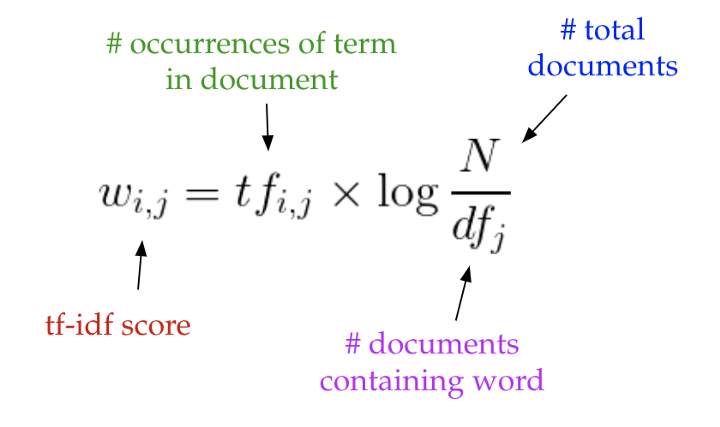

In [126]:
Image("1*jNnpbGPxkjehlvTCXq9B8g.png")

In [127]:
!wget https://upload.wikimedia.org/wikipedia/commons/d/d3/3-log-plot.png

--2022-01-24 10:50:27--  https://upload.wikimedia.org/wikipedia/commons/d/d3/3-log-plot.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117934 (115K) [image/png]
Saving to: ‘3-log-plot.png.1’

3-log-plot.png.1    100%[===================>] 115.17K  --.-KB/s    in 0.03s   

2022-01-24 10:50:27 (3.63 MB/s) - ‘3-log-plot.png.1’ saved [117934/117934]



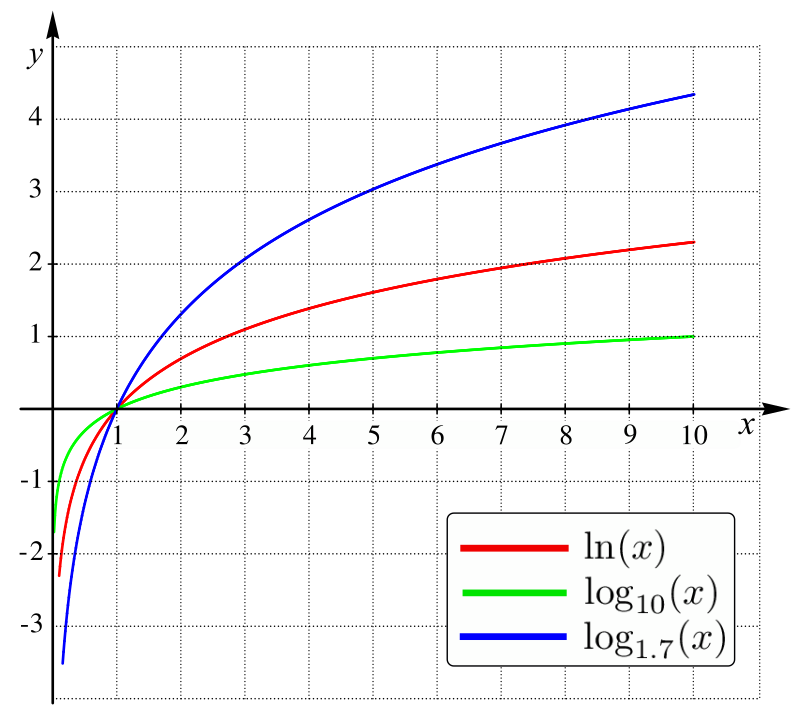

In [128]:
Image("https://upload.wikimedia.org/wikipedia/commons/d/d3/3-log-plot.png", height = 500, width = 500)

In [129]:
#Importamos TfIdfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Quitamos todas las stop words ("the", "a", etc.).
tfidf = TfidfVectorizer(stop_words='english')

#Calculamos la matriz tf-idf
tfidf_matrix = tfidf.fit_transform(joined_df['overview'])

Se han usado 20k+ palabras para describir las 4800+ películas de nuestro dataset

In [130]:
tfidf_matrix.shape

(4803, 20978)

In [131]:
tfidf_matrix

<4803x20978 sparse matrix of type '<class 'numpy.float64'>'
	with 125840 stored elements in Compressed Sparse Row format>

In [132]:
joined_df[['title','overview']]

,title,overview
0,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,Following the death of District Attorney Harve...
4,John Carter,"John Carter is a war-weary, former military ca..."
...,...,...
4798,El Mariachi,El Mariachi just wants to play his guitar and ...
4799,Newlyweds,A newlywed couple's honeymoon is upended by th...
4800,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic..."
4801,Shanghai Calling,When ambitious New York attorney Sam is sent t...


In [133]:
tfidf_matrix_df = pd.DataFrame(tfidf_matrix.toarray())
tfidf_matrix_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,20938,20939,20940,20941,20942,20943,20944,20945,20946,20947,20948,20949,20950,20951,20952,20953,20954,20955,20956,20957,20958,20959,20960,20961,20962,20963,20964,20965,20966,20967,20968,20969,20970,20971,20972,20973,20974,20975,20976,20977
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
tfidf.get_feature_names()[2000:2010]

['benito',
 'benjamin',
 'benmahmoud',
 'bennell',
 'bennet',
 'bennett',
 'bennigan',
 'benoit',
 'benoît',
 'benson']

In [135]:
tfidf_matrix_df.columns = tfidf.get_feature_names()

In [136]:
tfidf_matrix_df

,00,000,007,07am,10,100,1000,101,108,10th,11,114,117,118,119,11th,12,1200,1215,1250,125th,12th,13,1300,13th,14,140,1408,142,1429,148,14pm,14th,15,150,150th,1520s,1536,15th,16,...,zimm,zimmer,zinnemann,zinos,zion,zip,zips,zira,zisman,zissou,ziyi,zod,zodiac,zoe,zohan,zohre,zombie,zombieland,zombies,zone,zones,zoo,zooey,zookeeper,zoolander,zoologists,zoom,zoozie,zorin,zorro,zuckerberg,zula,zuzu,zyklon,æon,éloigne,émigré,été,única,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
joined_df[['title','overview']][0:1].values

array([['Avatar',
        'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.']],
      dtype=object)

In [138]:
tfidf_matrix_df[['century','paraplegic','marine','civilization','moon','mission']]

,century,paraplegic,marine,civilization,moon,mission
0,0.19886,0.341139,0.258027,0.274933,0.271554,0.177845
1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
4798,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4799,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4800,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4801,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


###Cosine similarity

In [139]:
!wget https://i.stack.imgur.com/36r1U.png

--2022-01-24 10:50:29--  https://i.stack.imgur.com/36r1U.png
Resolving i.stack.imgur.com (i.stack.imgur.com)... 151.101.248.193
Connecting to i.stack.imgur.com (i.stack.imgur.com)|151.101.248.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10219 (10.0K) [image/png]
Saving to: ‘36r1U.png.1’

36r1U.png.1         100%[===================>]   9.98K  --.-KB/s    in 0s      

2022-01-24 10:50:29 (92.7 MB/s) - ‘36r1U.png.1’ saved [10219/10219]



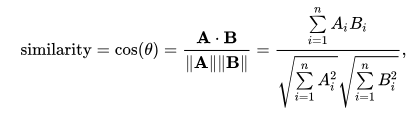

In [140]:
Image("36r1U.png")

In [141]:
!wget https://zhangruochi.com/Operations-on-word-vectors-Debiasing/2019/03/28/images/cosine_sim.png

--2022-01-24 10:50:29--  https://zhangruochi.com/Operations-on-word-vectors-Debiasing/2019/03/28/images/cosine_sim.png
Resolving zhangruochi.com (zhangruochi.com)... 185.199.109.153, 185.199.108.153
Connecting to zhangruochi.com (zhangruochi.com)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106128 (104K) [image/png]
Saving to: ‘cosine_sim.png.1’

cosine_sim.png.1    100%[===================>] 103.64K  --.-KB/s    in 0.02s   

2022-01-24 10:50:29 (4.88 MB/s) - ‘cosine_sim.png.1’ saved [106128/106128]



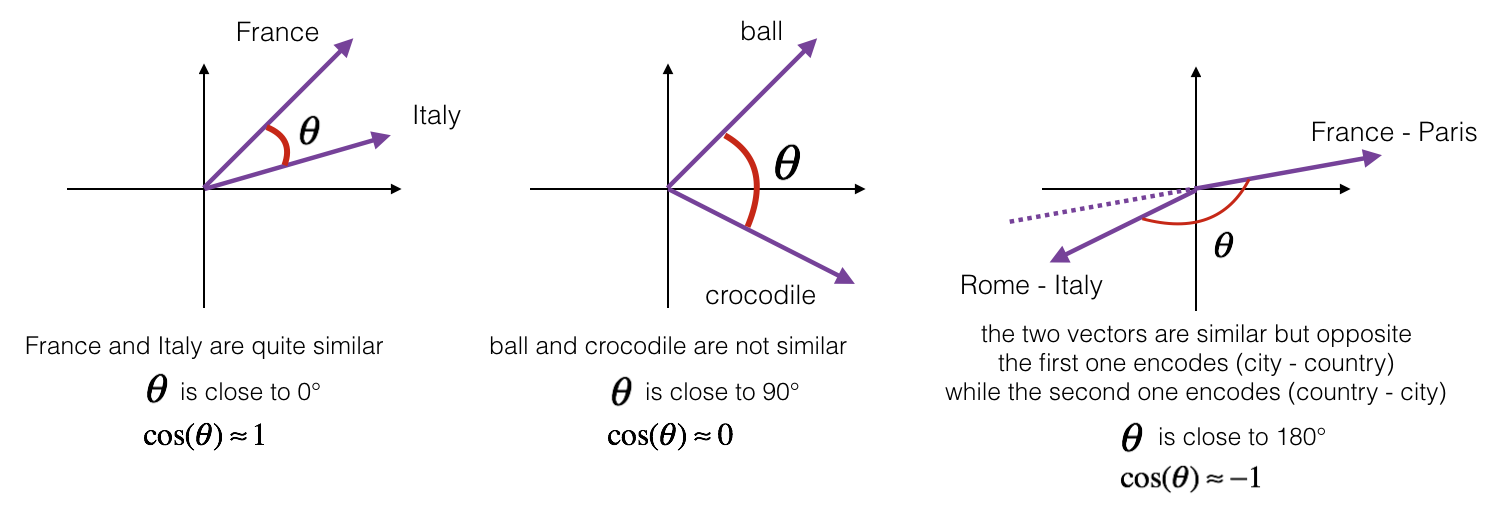

In [142]:
Image("cosine_sim.png")

In [143]:
tfidf_matrix_df

,00,000,007,07am,10,100,1000,101,108,10th,11,114,117,118,119,11th,12,1200,1215,1250,125th,12th,13,1300,13th,14,140,1408,142,1429,148,14pm,14th,15,150,150th,1520s,1536,15th,16,...,zimm,zimmer,zinnemann,zinos,zion,zip,zips,zira,zisman,zissou,ziyi,zod,zodiac,zoe,zohan,zohre,zombie,zombieland,zombies,zone,zones,zoo,zooey,zookeeper,zoolander,zoologists,zoom,zoozie,zorin,zorro,zuckerberg,zula,zuzu,zyklon,æon,éloigne,émigré,été,única,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160533, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01488159, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160533, 0.01488159, ..., 1.        , 0.01609091,
        0.00701914],
       [0.        , 0.        , 0.        , ..., 0.01609091, 1.        ,
        0.01171696],
       [0.        , 0.        , 0.        , ..., 0.00701914, 0.01171696,
        1.        ]])

In [145]:
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.columns = joined_df['title']
cosine_sim_df['title'] = joined_df['title']


cols = list(cosine_sim_df.columns)
cols = [cols[-1]] + cols[:-1]#Ponemos la última columna como la primera
cosine_sim_df = cosine_sim_df[cols]

cosine_sim_df['overview'] = joined_df['overview']
cosine_sim_df

title,title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,Superman Returns,Quantum of Solace,Pirates of the Caribbean: Dead Man's Chest,The Lone Ranger,Man of Steel,The Chronicles of Narnia: Prince Caspian,The Avengers,Pirates of the Caribbean: On Stranger Tides,Men in Black 3,The Hobbit: The Battle of the Five Armies,The Amazing Spider-Man,Robin Hood,The Hobbit: The Desolation of Smaug,The Golden Compass,King Kong,Titanic,Captain America: Civil War,Battleship,Jurassic World,Skyfall,Spider-Man 2,Iron Man 3,Alice in Wonderland,X-Men: The Last Stand,Monsters University,Transformers: Revenge of the Fallen,Transformers: Age of Extinction,Oz: The Great and Powerful,The Amazing Spider-Man 2,...,Dawn of the Crescent Moon,Raymond Did It,The Last Waltz,"Run, Hide, Die",The Exploding Girl,The Legend of God's Gun,Mutual Appreciation,Her Cry: La Llorona Investigation,Down Terrace,Clerks,Pink Narcissus,Funny Ha Ha,In the Company of Men,Manito,Rampage,Slacker,Dutch Kills,Dry Spell,Flywheel,Backmask,The Puffy Chair,Stories of Our Lives,Breaking Upwards,All Superheroes Must Die,Pink Flamingos,Clean,The Circle,Tin Can Man,Cure,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew,overview
0,Avatar,1.000000,0.000000,0.000000,0.024995,0.000000,0.030353,0.000000,0.037581,0.000000,0.000000,0.000000,0.019788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.034970,0.047055,0.000000,0.025185,0.00000,0.061534,0.000000,0.0,0.0,0.000000,0.074546,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.029175,0.042176,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,0.000000,1.000000,0.000000,0.000000,0.033369,0.000000,0.000000,0.022676,0.000000,0.000000,0.000000,0.000000,0.050839,0.000000,0.036632,0.007443,0.000000,0.032567,0.008340,0.018219,0.006358,0.000000,0.0,0.000000,0.000000,0.005118,0.036645,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.013252,0.021844,0.000000,0.025478,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.009379,0.012083,0.013650,0.018175,0.010143,0.000000,0.018211,0.008614,0.018056,0.006907,0.009857,0.006438,0.000000,0.000000,0.0,0.0,0.015251,0.000000,0.000000,0.000000,0.006895,0.000000,0.000000,0.000000,0.0,0.021605,0.000000,0.000000,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.030949,0.024830,0.000000,0.000000,0.165090,0.000000,0.000000,0.000000,0.000000,0.000000,0.052149,0.033391,0.000000,0.000000,0.000000,0.0,0.018329,0.000000,0.000000,0.000000,0.000000,0.000000,0.134112,0.00000,0.000000,0.000000,0.0,0.0,0.075706,0.015518,0.000000,0.013552,...,0.000000,0.000000,0.0,0.063869,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.024927,0.000000,0.000000,0.000000,0.000000,0.019865,0.000000,0.000000,0.000000,0.000000,0.028601,0.0,0.0,0.000000,0.000000,0.027695,0.000000,0.000000,0.000000,0.017768,0.000000,0.0,0.014882,0.000000,0.000000,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,0.024995,0.000000,0.000000,1.000000,0.010433,0.005145,0.012601,0.026954,0.020652,0.133740,0.000000,0.000000,0.000000,0.000000,0.000000,0.004071,0.021121,0.000000,0.006769,0.010765,0.007178,0.033381,0.0,0.000000,0.019238,0.017013,0.018846,0.000000,0.008351,0.025822,0.01755,0.029948,0.021709,0.0,0.0,0.000000,0.028418,0.000000,0.030632,...,0.000000

In [146]:
cosine_sim_df.sort_values(by="Spider-Man 3",ascending=False)[['title',"Spider-Man 3","overview"]].head(10)

title,title,Spider-Man 3,overview
5,Spider-Man 3,1.000000,The seemingly invincible Spider-Man goes up ag...
159,Spider-Man,0.282694,After being bitten by a genetically altered sp...
30,Spider-Man 2,0.246472,Peter Parker is going through a major identity...
1534,Arachnophobia,0.236710,A large spider from the jungles of South Ameri...
20,The Amazing Spider-Man,0.222847,Peter Parker is an outcast high schooler aband...
38,The Amazing Spider-Man 2,0.211396,"For Peter Parker, life is busy. Between taking..."
1318,The Thing,0.171669,Scientists in the Antarctic are confronted by ...
4664,Bronson,0.101190,A young man who was sentenced to 7 years in pr...
3610,Not Easily Broken,0.096983,A car accident and shifting affections test th...
4456,Raising Victor Vargas,0.094412,"The film follows Victor, a Lower East Side tee..."


Hacemos un método que nos devuelva el top 10 de películas más similares a la que pasemos como entrada

In [147]:
def get_top_10_recommendations(movie_title):
  return cosine_sim_df.sort_values(by=movie_title,ascending=False)['title'][1:11] #Quitamos la primera porque es ella misma

In [148]:
get_top_10_recommendations("The Dark Knight Rises")

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [149]:
get_top_10_recommendations("The Hobbit: An Unexpected Journey")

22                    The Hobbit: The Desolation of Smaug
19              The Hobbit: The Battle of the Five Armies
262     The Lord of the Rings: The Fellowship of the Ring
1442                                    The Shipping News
160                            How to Train Your Dragon 2
1044                   Journey to the Center of the Earth
4272                                Journey from the Fall
2192                         The Greatest Story Ever Told
313                                     The Peanuts Movie
2937                                             Out Cold
Name: title, dtype: object

In [150]:
get_top_10_recommendations("The Wolverine")

122        X-Men Origins: Wolverine
1235                           Rent
2209             3 Ninjas Kick Back
1611    Mortal Kombat: Annihilation
511                           X-Men
107                        Warcraft
2100                  Mortal Kombat
1592                     Black Rain
4295                Monsoon Wedding
3081                     The Forest
Name: title, dtype: object

In [151]:
get_top_10_recommendations("Star Wars: Episode III - Revenge of the Sith")

230     Star Wars: Episode II - Attack of the Clones
233        Star Wars: Episode I - The Phantom Menace
3208                 Star Wars: Clone Wars: Volume 1
1990                         The Empire Strikes Back
3184                                 The Ice Pirates
1490                              Return of the Jedi
3405                      Stargate: The Ark of Truth
422                                      The 6th Day
2912                                       Star Wars
1068            The Hitchhiker's Guide to the Galaxy
Name: title, dtype: object

¿Alguna que queráis probar?

In [152]:
with np.printoptions(threshold = np.inf):
   print(np.array(cosine_sim_df['title'].unique()))

['Avatar' "Pirates of the Caribbean: At World's End" 'Spectre'
 'The Dark Knight Rises' 'John Carter' 'Spider-Man 3' 'Tangled'
 'Avengers: Age of Ultron' 'Harry Potter and the Half-Blood Prince'
 'Batman v Superman: Dawn of Justice' 'Superman Returns'
 'Quantum of Solace' "Pirates of the Caribbean: Dead Man's Chest"
 'The Lone Ranger' 'Man of Steel'
 'The Chronicles of Narnia: Prince Caspian' 'The Avengers'
 'Pirates of the Caribbean: On Stranger Tides' 'Men in Black 3'
 'The Hobbit: The Battle of the Five Armies' 'The Amazing Spider-Man'
 'Robin Hood' 'The Hobbit: The Desolation of Smaug' 'The Golden Compass'
 'King Kong' 'Titanic' 'Captain America: Civil War' 'Battleship'
 'Jurassic World' 'Skyfall' 'Spider-Man 2' 'Iron Man 3'
 'Alice in Wonderland' 'X-Men: The Last Stand' 'Monsters University'
 'Transformers: Revenge of the Fallen' 'Transformers: Age of Extinction'
 'Oz: The Great and Powerful' 'The Amazing Spider-Man 2' 'TRON: Legacy'
 'Cars 2' 'Green Lantern' 'Toy Story 3' 'Termin

Ahora bien, este método tiene un problema. ¿Qué pasa si yo quiero que con Batman me recomiende también otras películas dirigidas por Nolan? No sólo las de Batman...

In [153]:
get_top_10_recommendations("The Dark Knight Rises")

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

### Recomendación por créditos, géneros y palabras clave

In [154]:
joined_df.columns

Index(['id', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count'],
      dtype='object')

In [155]:
joined_df[['title','cast','crew','keywords','genres']]

,title,cast,crew,keywords,genres
0,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
1,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""..."
2,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
3,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam..."
4,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
...,...,...,...,...,...
4798,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...","[{""id"": 5616, ""name"": ""united states\u2013mexi...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam..."
4799,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...",[],"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""..."
4800,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de...","[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...","[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam..."
4801,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de...",[],[]


In [156]:
joined_df[['title','cast','crew','keywords','genres']].head().values

array([['Avatar',
        '[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe4800925

Convertimos los objetos de estructura de diccionarios a Python

In [157]:
joined_df[['title','cast','crew','keywords','genres']].dtypes

title       object
cast        object
crew        object
keywords    object
genres      object
dtype: object

In [158]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    joined_df[feature] = joined_df[feature].apply(literal_eval)

In [159]:
joined_df[['title','cast','crew','keywords','genres']].dtypes

title       object
cast        object
crew        object
keywords    object
genres      object
dtype: object

Créditos de Avatar

In [160]:
joined_df['crew'][0:1].values[0]

[{'credit_id': '52fe48009251416c750aca23',
  'department': 'Editing',
  'gender': 0,
  'id': 1721,
  'job': 'Editor',
  'name': 'Stephen E. Rivkin'},
 {'credit_id': '539c47ecc3a36810e3001f87',
  'department': 'Art',
  'gender': 2,
  'id': 496,
  'job': 'Production Design',
  'name': 'Rick Carter'},
 {'credit_id': '54491c89c3a3680fb4001cf7',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Designer',
  'name': 'Christopher Boyes'},
 {'credit_id': '54491cb70e0a267480001bd0',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Supervising Sound Editor',
  'name': 'Christopher Boyes'},
 {'credit_id': '539c4a4cc3a36810c9002101',
  'department': 'Production',
  'gender': 1,
  'id': 1262,
  'job': 'Casting',
  'name': 'Mali Finn'},
 {'credit_id': '5544ee3b925141499f0008fc',
  'department': 'Sound',
  'gender': 2,
  'id': 1729,
  'job': 'Original Music Composer',
  'name': 'James Horner'},
 {'credit_id': '52fe48009251416c750ac9c3',
  'department': 'Directing',
  

In [161]:
for i in joined_df['crew'][0:1].values[0]:
  if i['job'] == 'Director':
    print(i)

{'credit_id': '52fe48009251416c750ac9c3', 'department': 'Directing', 'gender': 2, 'id': 2710, 'job': 'Director', 'name': 'James Cameron'}


Escribimos una función para extraer el director de cada película

In [162]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan #En el caso de que no venga el director, devolvemos un valor nulo

In [163]:
joined_df['director'] = joined_df['crew'].apply(get_director)

In [164]:
joined_df[['title','director']]

,title,director
0,Avatar,James Cameron
1,Pirates of the Caribbean: At World's End,Gore Verbinski
2,Spectre,Sam Mendes
3,The Dark Knight Rises,Christopher Nolan
4,John Carter,Andrew Stanton
...,...,...
4798,El Mariachi,Robert Rodriguez
4799,Newlyweds,Edward Burns
4800,"Signed, Sealed, Delivered",Scott Smith
4801,Shanghai Calling,Daniel Hsia


In [165]:
joined_df['cast'][0:1].values[0]

[{'cast_id': 242,
  'character': 'Jake Sully',
  'credit_id': '5602a8a7c3a3685532001c9a',
  'gender': 2,
  'id': 65731,
  'name': 'Sam Worthington',
  'order': 0},
 {'cast_id': 3,
  'character': 'Neytiri',
  'credit_id': '52fe48009251416c750ac9cb',
  'gender': 1,
  'id': 8691,
  'name': 'Zoe Saldana',
  'order': 1},
 {'cast_id': 25,
  'character': 'Dr. Grace Augustine',
  'credit_id': '52fe48009251416c750aca39',
  'gender': 1,
  'id': 10205,
  'name': 'Sigourney Weaver',
  'order': 2},
 {'cast_id': 4,
  'character': 'Col. Quaritch',
  'credit_id': '52fe48009251416c750ac9cf',
  'gender': 2,
  'id': 32747,
  'name': 'Stephen Lang',
  'order': 3},
 {'cast_id': 5,
  'character': 'Trudy Chacon',
  'credit_id': '52fe48009251416c750ac9d3',
  'gender': 1,
  'id': 17647,
  'name': 'Michelle Rodriguez',
  'order': 4},
 {'cast_id': 8,
  'character': 'Selfridge',
  'credit_id': '52fe48009251416c750ac9e1',
  'gender': 2,
  'id': 1771,
  'name': 'Giovanni Ribisi',
  'order': 5},
 {'cast_id': 7,
  'c

In [166]:
joined_df['keywords'][0:1].values[0]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [167]:
joined_df['genres'][0:1].values[0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

Función para quedarnos con los 3 primeros elementos de la lista

In [168]:
def get_list(x):
    if isinstance(x, list):#Comprobamos que es una lista
        names = [i['name'] for i in x]#Nos quedamos con el valor del nombre
        
        if len(names) > 3:#Si hay más de 3 nombres, cogemos los 3 primeros
            names = names[:3]
        return names#Si no, devolvemos los nombres tal cual

    #Si no es una lista, devolvemos vacío
    return []

In [169]:
features = ['cast', 'keywords', 'genres']
for feature in features:
    joined_df[feature] = joined_df[feature].apply(get_list)

In [170]:
joined_df[['title','director','cast','keywords','genres']]

,title,director,cast,keywords,genres
0,Avatar,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]","[spy, based on novel, secret agent]","[Action, Adventure, Crime]"
3,The Dark Knight Rises,Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]","[dc comics, crime fighter, terrorist]","[Action, Crime, Drama]"
4,John Carter,Andrew Stanton,"[Taylor Kitsch, Lynn Collins, Samantha Morton]","[based on novel, mars, medallion]","[Action, Adventure, Science Fiction]"
...,...,...,...,...,...
4798,El Mariachi,Robert Rodriguez,"[Carlos Gallardo, Jaime de Hoyos, Peter Marqua...","[united states–mexico barrier, legs, arms]","[Action, Crime, Thriller]"
4799,Newlyweds,Edward Burns,"[Edward Burns, Kerry Bishé, Marsha Dietlein]",[],"[Comedy, Romance]"
4800,"Signed, Sealed, Delivered",Scott Smith,"[Eric Mabius, Kristin Booth, Crystal Lowe]","[date, love at first sight, narration]","[Comedy, Drama, Romance]"
4801,Shanghai Calling,Daniel Hsia,"[Daniel Henney, Eliza Coupe, Bill Paxton]",[],[]


Limpiamos el texto:

In [171]:
def clean_data(x):
    if isinstance(x, list):#Lista (cast, keywords, genres)
        return [str.lower(i.replace(" ", "")) for i in x]#Convertimos todo a minúsculas
    else:
        if isinstance(x, str):#String (director)
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [172]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    joined_df[feature] = joined_df[feature].apply(clean_data)

Despué de haber hecho esto, nos aseguramos de que, por ejemplo, "Johnny Depp" no es igual que "Johnny Galecki"

In [173]:
joined_df[['title','director','cast','keywords','genres']]

,title,director,cast,keywords,genres
0,Avatar,jamescameron,"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley]","[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,sammendes,"[danielcraig, christophwaltz, léaseydoux]","[spy, basedonnovel, secretagent]","[action, adventure, crime]"
3,The Dark Knight Rises,christophernolan,"[christianbale, michaelcaine, garyoldman]","[dccomics, crimefighter, terrorist]","[action, crime, drama]"
4,John Carter,andrewstanton,"[taylorkitsch, lynncollins, samanthamorton]","[basedonnovel, mars, medallion]","[action, adventure, sciencefiction]"
...,...,...,...,...,...
4798,El Mariachi,robertrodriguez,"[carlosgallardo, jaimedehoyos, petermarquardt]","[unitedstates–mexicobarrier, legs, arms]","[action, crime, thriller]"
4799,Newlyweds,edwardburns,"[edwardburns, kerrybishé, marshadietlein]",[],"[comedy, romance]"
4800,"Signed, Sealed, Delivered",scottsmith,"[ericmabius, kristinbooth, crystallowe]","[date, loveatfirstsight, narration]","[comedy, drama, romance]"
4801,Shanghai Calling,danielhsia,"[danielhenney, elizacoupe, billpaxton]",[],[]


In [174]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

joined_df['metadata'] =  joined_df.apply(create_soup, axis=1)

In [175]:
joined_df[['title','director','cast','keywords','genres','metadata']]

,title,director,cast,keywords,genres,metadata
0,Avatar,jamescameron,"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar]","[action, adventure, fantasy]",cultureclash future spacewar samworthington zo...
1,Pirates of the Caribbean: At World's End,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley]","[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]",ocean drugabuse exoticisland johnnydepp orland...
2,Spectre,sammendes,"[danielcraig, christophwaltz, léaseydoux]","[spy, basedonnovel, secretagent]","[action, adventure, crime]",spy basedonnovel secretagent danielcraig chris...
3,The Dark Knight Rises,christophernolan,"[christianbale, michaelcaine, garyoldman]","[dccomics, crimefighter, terrorist]","[action, crime, drama]",dccomics crimefighter terrorist christianbale ...
4,John Carter,andrewstanton,"[taylorkitsch, lynncollins, samanthamorton]","[basedonnovel, mars, medallion]","[action, adventure, sciencefiction]",basedonnovel mars medallion taylorkitsch lynnc...
...,...,...,...,...,...,...
4798,El Mariachi,robertrodriguez,"[carlosgallardo, jaimedehoyos, petermarquardt]","[unitedstates–mexicobarrier, legs, arms]","[action, crime, thriller]",unitedstates–mexicobarrier legs arms carlosgal...
4799,Newlyweds,edwardburns,"[edwardburns, kerrybishé, marshadietlein]",[],"[comedy, romance]",edwardburns kerrybishé marshadietlein edwardb...
4800,"Signed, Sealed, Delivered",scottsmith,"[ericmabius, kristinbooth, crystallowe]","[date, loveatfirstsight, narration]","[comedy, drama, romance]",date loveatfirstsight narration ericmabius kri...
4801,Shanghai Calling,danielhsia,"[danielhenney, elizacoupe, billpaxton]",[],[],danielhenney elizacoupe billpaxton danielhsia


Ahora vamos a hacer algo similar a lo que hicimos con TF-IDF con el "overview" de las películas. No obstante, esta vez usamos CountVectorizer en vez de TF-IDF. Funciona de forma similar, pero no da menos valor a las palabras que aparecen en muchos documentos (películas). ¡No queremos que se dé menos valor a un actor/director sólo porque haya actuado o dirigido muchas películas!

In [176]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(joined_df['metadata'])

Calculamos cosine similarity

In [177]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [178]:
pd.DataFrame(cosine_sim2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4763,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773,4774,4775,4776,4777,4778,4779,4780,4781,4782,4783,4784,4785,4786,4787,4788,4789,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802
0,1.000000,0.300000,0.200000,0.100000,0.200000,0.300000,0.0,0.200000,0.2,0.300000,0.300000,0.200000,0.300000,0.200000,0.300000,0.2,0.200000,0.300000,0.100000,0.300000,0.300000,0.210819,0.210819,0.210819,0.200000,0.100000,0.200000,0.200000,0.200000,0.200000,0.286039,0.200000,0.2,0.200000,0.0,0.200000,0.200000,0.2,0.300000,0.200000,...,0.000000,0.000000,0.0,0.0,0.0000,0.000000,0.129099,0.000000,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095346,0.000000,0.000000,0.0,0.0
1,0.300000,1.000000,0.200000,0.100000,0.200000,0.300000,0.0,0.200000,0.2,0.300000,0.300000,0.200000,0.700000,0.400000,0.300000,0.2,0.200000,0.400000,0.100000,0.300000,0.300000,0.210819,0.210819,0.210819,0.200000,0.000000,0.200000,0.200000,0.200000,0.200000,0.286039,0.200000,0.3,0.200000,0.0,0.200000,0.200000,0.2,0.300000,0.200000,...,0.000000,0.000000,0.0,0.0,0.0000,0.000000,0.129099,0.000000,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095346,0.000000,0.000000,0.0,0.0
2,0.200000,0.200000,1.000000,0.200000,0.300000,0.200000,0.0,0.200000,0.1,0.200000,0.200000,0.400000,0.200000,0.200000,0.200000,0.2,0.200000,0.200000,0.100000,0.200000,0.200000,0.210819,0.105409,0.210819,0.200000,0.000000,0.200000,0.200000,0.200000,0.600000,0.190693,0.200000,0.2,0.200000,0.0,0.200000,0.200000,0.1,0.200000,0.200000,...,0.000000,0.000000,0.0,0.0,0.0000,0.000000,0.129099,0.000000,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.119523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190693,0.000000,0.000000,0.0,0.0
3,0.100000,0.100000,0.200000,1.000000,0.100000,0.100000,0.0,0.100000,0.0,0.200000,0.200000,0.100000,0.100000,0.100000,0.200000,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.105409,0.000000,0.000000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000,0.095346,0.200000,0.0,0.100000,0.0,0.100000,0.100000,0.0,0.100000,0.100000,...,0.000000,0.119523,0.0,0.0,0.0000,0.119523,0.129099,0.095346,0.0,0.200000,0.000000,0.105409,0.119523,0.105409,0.141421,0.300000,0.000000,0.239046,0.000000,0.105409,0.000000,0.111803,0.141421,0.000000,0.000000,0.100000,0.111803,0.129099,0.0,0.100000,0.111803,0.000000,0.105409,0.091287,0.000000,0.190693,0.000000,0.100000,0.0,0.0
4,0.200000,0.200000,0.300000,0.100000,1.000000,0.200000,0.0,0.300000,0.1,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.2,0.300000,0.200000,0.200000,0.200000,0.200000,0.210819,0.105409,0.105409,0.200000,0.000000,0.300000,0.300000,0.300000,0.200000,0.190693,0.300000,0.2,0.300000,0.0,0.300000,0.300000,0.1,0.200000,0.300000,...,0.000000,0.119523,0.0,0.0,0.0000,0.000000,0.129099,0.000000,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105409,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.091287,0.000000,0.095346,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0.095346,0.095346,0.190693,0.190

In [179]:
cosine_sim2_df = pd.DataFrame(cosine_sim2)

cosine_sim2_df.columns = joined_df['title']
cosine_sim2_df['title'] = joined_df['title']

cols = list(cosine_sim2_df.columns)
cols = [cols[-1]] + cols[:-1]#Ponemos la última columna como la primera
cosine_sim2_df = cosine_sim2_df[cols]


cosine_sim2_df['director'] = joined_df['director']
cosine_sim2_df['cast'] = joined_df['cast']
cosine_sim2_df['keywords'] = joined_df['keywords']
cosine_sim2_df['genres'] = joined_df['genres']
cosine_sim2_df['metadata'] = joined_df['metadata']

cosine_sim2_df

title,title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,Superman Returns,Quantum of Solace,Pirates of the Caribbean: Dead Man's Chest,The Lone Ranger,Man of Steel,The Chronicles of Narnia: Prince Caspian,The Avengers,Pirates of the Caribbean: On Stranger Tides,Men in Black 3,The Hobbit: The Battle of the Five Armies,The Amazing Spider-Man,Robin Hood,The Hobbit: The Desolation of Smaug,The Golden Compass,King Kong,Titanic,Captain America: Civil War,Battleship,Jurassic World,Skyfall,Spider-Man 2,Iron Man 3,Alice in Wonderland,X-Men: The Last Stand,Monsters University,Transformers: Revenge of the Fallen,Transformers: Age of Extinction,Oz: The Great and Powerful,The Amazing Spider-Man 2,...,The Exploding Girl,The Legend of God's Gun,Mutual Appreciation,Her Cry: La Llorona Investigation,Down Terrace,Clerks,Pink Narcissus,Funny Ha Ha,In the Company of Men,Manito,Rampage,Slacker,Dutch Kills,Dry Spell,Flywheel,Backmask,The Puffy Chair,Stories of Our Lives,Breaking Upwards,All Superheroes Must Die,Pink Flamingos,Clean,The Circle,Tin Can Man,Cure,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew,director,cast,keywords,genres,metadata
0,Avatar,1.000000,0.300000,0.200000,0.100000,0.200000,0.300000,0.0,0.200000,0.2,0.300000,0.300000,0.200000,0.300000,0.200000,0.300000,0.2,0.200000,0.300000,0.100000,0.300000,0.300000,0.210819,0.210819,0.210819,0.200000,0.100000,0.200000,0.200000,0.200000,0.200000,0.286039,0.200000,0.2,0.200000,0.0,0.200000,0.200000,0.2,0.300000,...,0.000000,0.129099,0.000000,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095346,0.000000,0.000000,0.0,0.0,jamescameron,"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar]","[action, adventure, fantasy]",cultureclash future spacewar samworthington zo...
1,Pirates of the Caribbean: At World's End,0.300000,1.000000,0.200000,0.100000,0.200000,0.300000,0.0,0.200000,0.2,0.300000,0.300000,0.200000,0.700000,0.400000,0.300000,0.2,0.200000,0.400000,0.100000,0.300000,0.300000,0.210819,0.210819,0.210819,0.200000,0.000000,0.200000,0.200000,0.200000,0.200000,0.286039,0.200000,0.3,0.200000,0.0,0.200000,0.200000,0.2,0.300000,...,0.000000,0.129099,0.000000,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095346,0.000000,0.000000,0.0,0.0,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley]","[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]",ocean drugabuse exoticisland johnnydepp orland...
2,Spectre,0.200000,0.200000,1.000000,0.200000,0.300000,0.200000,0.0,0.200000,0.1,0.200000,0.200000,0.400000,0.200000,0.200000,0.200000,0.2,0.200000,0.200000,0.100000,0.200000,0.200000,0.210819,0.105409,0.210819,0.200000,0.000000,0.200000,0.200000,0.200000,0.600000,0.190693,0.200000,0.2,0.200000,0.0,0.200000,0.200000,0.1,0.200000,...,0.000000,0.129099,0.000000,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.119523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.0,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190693,0.000000,0.000000,0.0,0.0,sammendes,"[danielcraig, christophwaltz, léaseydoux]","[spy, basedonnovel, secretagent]","[action, adventure, crime]",spy basedonnovel secretagent danielcraig chris...
3,The Dark Knight Rises,0.100000,0.100000,0.200000,1.000000,0.100000,0.100000,0.0,0.100000,0.0,0.200000,0.200000,0.100000,0.100000,0.100000,0.200000,0.0,

In [180]:
def get_top_10_recommendations(movie_title):
  return cosine_sim2_df.sort_values(by=movie_title,ascending=False)[['title','director','cast','keywords','genres']][0:11] #Quitamos la primera porque es ella misma

In [181]:
get_top_10_recommendations("The Dark Knight Rises")

title,title,director,cast,keywords,genres
3,The Dark Knight Rises,christophernolan,"[christianbale, michaelcaine, garyoldman]","[dccomics, crimefighter, terrorist]","[action, crime, drama]"
119,Batman Begins,christophernolan,"[christianbale, michaelcaine, liamneeson]","[himalaya, martialarts, dccomics]","[action, crime, drama]"
65,The Dark Knight,christophernolan,"[christianbale, heathledger, aaroneckhart]","[dccomics, crimefighter, secretidentity]","[drama, action, crime]"
4638,Amidst the Devil's Wings,,[],[],"[drama, action, crime]"
1196,The Prestige,christophernolan,"[hughjackman, christianbale, michaelcaine]","[competition, secret, obsession]","[drama, mystery, thriller]"
3073,Romeo Is Bleeding,petermedak,"[garyoldman, lenaolin, annabellasciorra]","[policeoperation, sexaddiction, police]","[action, crime, drama]"
3326,Black November,jetaamata,"[razaaqadoti, sarahwaynecallies, mickeyrourke]",[],"[drama, action, crime]"
1503,Takers,johnluessenhop,"[chrisbrown, haydenchristensen, mattdillon]",[heist],"[action, crime, drama]"
1986,Faster,"georgetillman,jr.","[dwaynejohnson, billybobthornton, maggiegrace]",[],"[crime, drama, action]"
1253,Kiss of Death,barbetschroeder,"[davidcaruso, samuell.jackson, nicolascage]",[hoodlum],"[action, crime, drama]"


In [182]:
get_top_10_recommendations("The Hobbit: An Unexpected Journey")

title,title,director,cast,keywords,genres
98,The Hobbit: An Unexpected Journey,peterjackson,"[ianmckellen, martinfreeman, richardarmitage]","[riddle, elves, dwarves]","[adventure, fantasy, action]"
19,The Hobbit: The Battle of the Five Armies,peterjackson,"[martinfreeman, ianmckellen, richardarmitage]","[corruption, elves, dwarves]","[action, adventure, fantasy]"
22,The Hobbit: The Desolation of Smaug,peterjackson,"[martinfreeman, ianmckellen, richardarmitage]","[elves, dwarves, orcs]","[adventure, fantasy]"
262,The Lord of the Rings: The Fellowship of the Ring,peterjackson,"[elijahwood, ianmckellen, cateblanchett]","[elves, dwarves, orcs]","[adventure, fantasy, action]"
329,The Lord of the Rings: The Return of the King,peterjackson,"[elijahwood, ianmckellen, viggomortensen]","[elves, orcs, middle-earth(tolkien)]","[adventure, fantasy, action]"
330,The Lord of the Rings: The Two Towers,peterjackson,"[elijahwood, ianmckellen, viggomortensen]","[elves, orcs, middle-earth(tolkien)]","[adventure, fantasy, action]"
1686,The Borrowers,peterhewitt,"[johngoodman, jimbroadbent, celiaimrie]","[dwarves, household, lawyer]","[adventure, fantasy, action]"
107,Warcraft,duncanjones,"[paulapatton, travisfimmel, benfoster]","[videogame, elves, orcs]","[action, adventure, fantasy]"
369,Lara Croft Tomb Raider: The Cradle of Life,jandebont,"[angelinajolie, gerardbutler, noahtaylor]","[riddle, treasure, medallion]","[action, adventure, fantasy]"
71,The Mummy: Tomb of the Dragon Emperor,robcohen,"[brendanfraser, jetli, johnhannah]",[],"[adventure, action, fantasy]"


In [183]:
get_top_10_recommendations("The Wolverine")

title,title,director,cast,keywords,genres
232,The Wolverine,jamesmangold,"[hughjackman, hiroyukisanada, famkejanssen]","[japan, samurai, mutant]","[action, sciencefiction, adventure]"
203,X2,bryansinger,"[patrickstewart, hughjackman, ianmckellen]","[mutant, marvelcomic, superhero]","[adventure, action, sciencefiction]"
33,X-Men: The Last Stand,brettratner,"[hughjackman, halleberry, ianmckellen]","[mutant, marvelcomic, basedoncomicbook]","[adventure, action, sciencefiction]"
511,X-Men,bryansinger,"[patrickstewart, hughjackman, ianmckellen]","[mutant, marvelcomic, superhero]","[adventure, action, sciencefiction]"
84,47 Ronin,carlrinsch,"[keanureeves, hiroyukisanada, koushibasaki]","[japan, suicide, samurai]","[drama, action, adventure]"
101,X-Men: First Class,matthewvaughn,"[jamesmcavoy, michaelfassbender, jenniferlawre...","[cia, mutant, mine]","[action, sciencefiction, adventure]"
122,X-Men Origins: Wolverine,gavinhood,"[hughjackman, lievschreiber, dannyhuston]","[corruption, mutant, boxer]","[adventure, action, thriller]"
46,X-Men: Days of Future Past,bryansinger,"[hughjackman, jamesmcavoy, michaelfassbender]","[1970s, mutant, timetravel]","[action, adventure, fantasy]"
1827,Teenage Mutant Ninja Turtles II: The Secret of...,michaelpressman,"[paigeturco, davidwarner, michelansisti]","[crimefighter, fight, mutant]","[sciencefiction, adventure, action]"
4401,The Helix... Loaded,,[],[],"[action, comedy, sciencefiction]"


In [184]:
get_top_10_recommendations("Star Wars: Episode III - Revenge of the Sith")

title,title,director,cast,keywords,genres
229,Star Wars: Episode III - Revenge of the Sith,georgelucas,"[ewanmcgregor, natalieportman, haydenchristensen]","[showdown, deathstar, vision]","[sciencefiction, adventure, action]"
230,Star Wars: Episode II - Attack of the Clones,georgelucas,"[ewanmcgregor, natalieportman, haydenchristensen]","[senate, investigation, army]","[adventure, action, sciencefiction]"
233,Star Wars: Episode I - The Phantom Menace,georgelucas,"[liamneeson, ewanmcgregor, natalieportman]","[prophecy, senate, queen]","[adventure, action, sciencefiction]"
2912,Star Wars,georgelucas,"[markhamill, harrisonford, carriefisher]","[android, galaxy, hermit]","[adventure, action, sciencefiction]"
4401,The Helix... Loaded,,[],[],"[action, comedy, sciencefiction]"
83,The Lovers,rolandjoffé,"[joshhartnett, simonekessell, tamsinegerton]",[],"[action, adventure, sciencefiction]"
1324,Virgin Territory,davidleland,"[ryancartwright, haydenchristensen, mischabarton]",[],"[adventure, action, comedy]"
4117,Six-String Samurai,lancemungia,"[jeffreyfalcon, justinmcguire, kimdeangelo]",[independentfilm],"[action, adventure, sciencefiction]"
1962,Jane Got a Gun,gavino'connor,"[natalieportman, joeledgerton, ewanmcgregor]",[],"[action, drama, western]"
193,After Earth,m.nightshyamalan,"[jadensmith, willsmith, sophieokonedo]",[dystopia],"[sciencefiction, action, adventure]"


###Filtrado colaborativo

Nuestro recomendador todavía no está dando recomendaciones basándose en el gusto del usuario. Para una película en concreto, todos recibirán las mismas recomendaciones, independientemente de quién sean

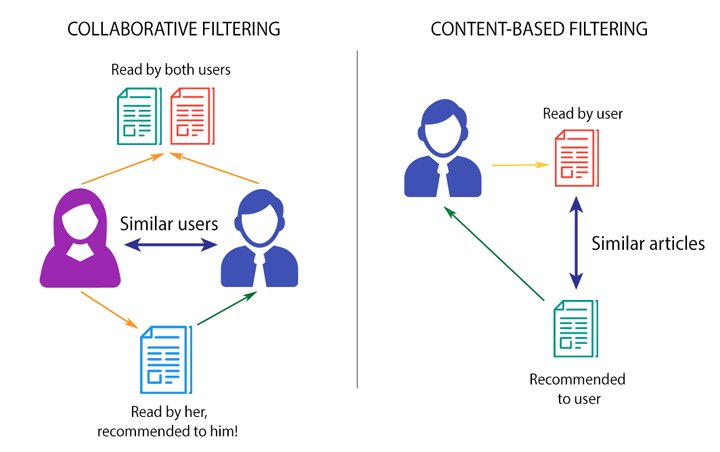

In [185]:
Image("recomsys.png__720x452_q85_subsampling-2.jpg")

Las matriz original de users-movies tiene dos problemas:

- Escalabilidad: la computación crece cuantos más usuarios y películas hay.
- Sparsity: los usuarios sólo ven unas pocas de películas de todo el catálogo, por lo que cada fila de usuario suele tener casi todo a cero.

Para tratar con estos dos problemas, se usa un método matemático llamado SVD, que aproxima la matriz user-movies a una dimensión menor.

In [186]:
!wget https://miro.medium.com/max/1838/1*2i-GJO7JX0Yz6498jUvhEg.png

--2022-01-24 10:50:41--  https://miro.medium.com/max/1838/1*2i-GJO7JX0Yz6498jUvhEg.png
Resolving miro.medium.com (miro.medium.com)... 162.159.152.4, 162.159.153.4, 2606:4700:7::a29f:9904, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.152.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58990 (58K) [image/png]
Saving to: ‘1*2i-GJO7JX0Yz6498jUvhEg.png.1’

1*2i-GJO7JX0Yz6498j 100%[===================>]  57.61K  --.-KB/s    in 0s      

2022-01-24 10:50:41 (115 MB/s) - ‘1*2i-GJO7JX0Yz6498jUvhEg.png.1’ saved [58990/58990]



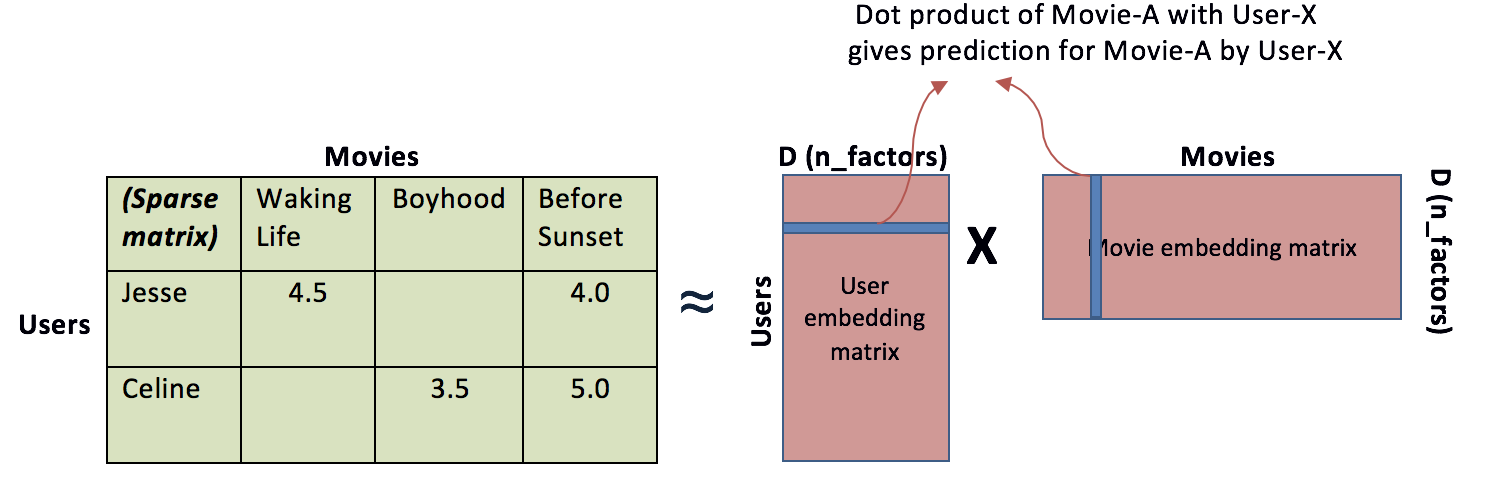

In [187]:
Image('1*2i-GJO7JX0Yz6498jUvhEg.png')

In [188]:
!wget https://kevinkolcheck.com/wp-content/uploads/2017/12/latent-factors.png

--2022-01-24 10:50:42--  https://kevinkolcheck.com/wp-content/uploads/2017/12/latent-factors.png
Resolving kevinkolcheck.com (kevinkolcheck.com)... 198.46.81.168
Connecting to kevinkolcheck.com (kevinkolcheck.com)|198.46.81.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78069 (76K) [image/png]
Saving to: ‘latent-factors.png.1’

latent-factors.png. 100%[===================>]  76.24K  --.-KB/s    in 0.04s   

2022-01-24 10:50:42 (2.01 MB/s) - ‘latent-factors.png.1’ saved [78069/78069]



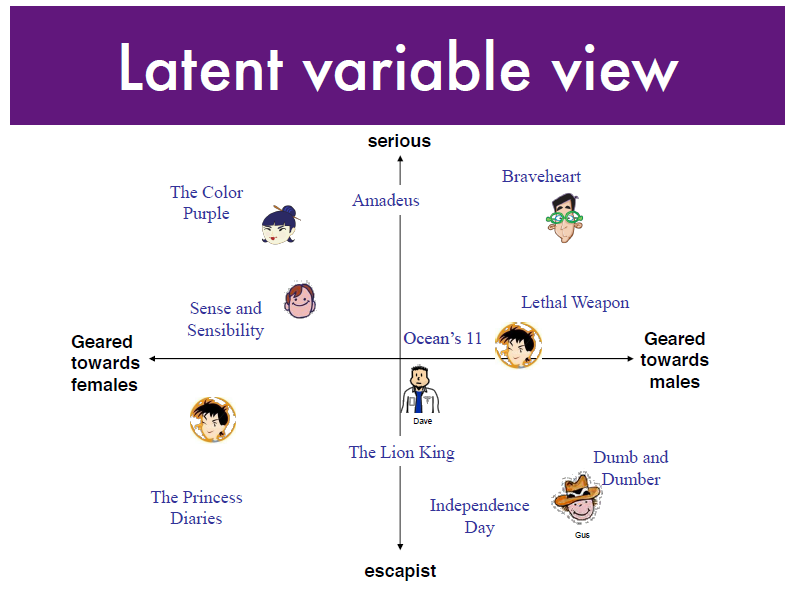

In [189]:
Image("latent-factors.png")

In [190]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader()
ratings = pd.read_csv('https://raw.githubusercontent.com/Suraj1127/movie-recommender/master/ratings_small.csv')
movies = pd.read_csv('https://raw.githubusercontent.com/jiyeon1997/movie-recommender-python/master/movies_metadata.csv')

In [191]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [192]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [193]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

Calculamos la descomposición en SVD:

In [194]:
svd = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9021  0.8914  0.8925  0.9025  0.8958  0.8968  0.0047  
MAE (testset)     0.6950  0.6848  0.6874  0.6945  0.6891  0.6902  0.0040  
Fit time          5.15    5.06    5.18    5.10    5.13    5.13    0.04    
Test time         0.20    0.37    0.16    0.36    0.18    0.26    0.09    


{'fit_time': (5.154444456100464,
  5.063695192337036,
  5.18127965927124,
  5.1011247634887695,
  5.126028537750244),
 'test_mae': array([0.69503034, 0.68480309, 0.68744026, 0.69452641, 0.68908146]),
 'test_rmse': array([0.9020696 , 0.89135515, 0.89250546, 0.9024746 , 0.89583595]),
 'test_time': (0.20116186141967773,
  0.3729701042175293,
  0.16195964813232422,
  0.3631584644317627,
  0.1830291748046875)}

Entrenamos el modelo con nuestros datos

In [195]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [196]:
movies['movieId'] = pd.to_numeric(movies['id'],errors='coerce')
movies['title'] = movies['title'].fillna('')
movies['vote_average'] = movies['vote_average']/2.0

ratings = ratings.merge(movies[['title','genres','movieId']])

In [197]:
USER_ID = 9
ratings[ratings['userId'] == USER_ID].sort_values(by='rating',ascending=False)

,userId,movieId,rating,timestamp,title,genres
18621,9,534,5.0,938628337,Terminator Salvation,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na..."
20935,9,608,5.0,938628843,Men in Black II,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
21159,9,1059,5.0,938629250,The Hidden Fortress,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '..."
15359,9,1682,5.0,938628690,Mothra vs. Godzilla,"[{'id': 14, 'name': 'Fantasy'}, {'id': 878, 'n..."
4518,9,527,5.0,938628843,Once Were Warriors,"[{'id': 18, 'name': 'Drama'}]"
5957,9,593,4.0,938628843,Solaris,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam..."
6412,9,318,4.0,938628966,The Million Dollar Hotel,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name..."
21350,9,1680,4.0,938629054,King Kong vs. Godzilla,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
21258,9,1584,4.0,938629341,School of Rock,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '..."
21493,9,2501,4.0,938628966,The Bourne Identity,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."


In [198]:
movies[movies['title'].str.contains("Godzilla")][['movieId','title','vote_average','vote_count']]

,movieId,title,vote_average,vote_count
1773,929.0,Godzilla,2.65,1075.0
2250,1678.0,Godzilla,3.45,194.0
2251,39256.0,Godzilla 1985,3.35,34.0
2252,1680.0,King Kong vs. Godzilla,3.00,48.0
3740,10643.0,Godzilla 2000,2.95,44.0
5501,1682.0,Mothra vs. Godzilla,3.20,38.0
5502,39462.0,Godzilla's Revenge,2.20,18.0
5503,18983.0,"Godzilla, King of the Monsters!",3.40,45.0
7809,38582.0,Godzilla vs. Mechagodzilla,3.15,36.0
9292,36243.0,"Godzilla, Mothra and King Ghidorah: Giant Mons...",3.10,23.0


In [199]:
prediction = svd.predict(USER_ID, 929)#Primer campo user id, segundo campo movie id
print(prediction.est)

3.453940913313643


In [200]:
prediction = svd.predict(USER_ID, 1680)#Primer campo user id, segundo campo movie id
print(prediction.est)

3.6967623214269865
